# Satellites Characterization
** EE-558, A Network Tour of Data Science ** <br>
** Lucas Gauchoux, Laurier Loiselle, Antoine Weber **

# 0. Abstract

# 1. Imports, global names and helper functions

In [145]:
%matplotlib inline

from pygsp import graphs, filters, plotting
from numpy import pi
import reverse_geocoder as rg
import networkx as nx
from scipy import sparse, stats, spatial, linalg
import matplotlib as mpl

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

from helpers import *

# 2. Data Acquisition

# 3. Data Exploration

As said before we retrieved three different files from the [SpaceTrack](https://www.space-track.org) website. The most important one is the file containing the [two-line elements](https://en.wikipedia.org/wiki/Two-line_element_set). We will therefore start exploring this one.

## 3.1 Two-Line Elements

A two line element is a data format containing a list of orbital information. Thos information allow us to compute the position of a satellite at a given time.
It looks like this:
    - 0 VANGUARD 2
    - 1    11U 59001A   17329.92226964 +.00000367 +00000-0 +19707-3 0  9992
    - 2    11 032.8697 323.5388 1468703 016.5820 347.7999 11.85506786164031
The first line is the name of the satellite and the following lines are the so calles two line element for this sattelite. The full description of each parameters can be found [here](https://en.wikipedia.org/wiki/Two-line_element_set#Format).
However we are interested in the position of satellites. In order to convert this raw data into a localisation we use the [pyephem](https://pypi.python.org/pypi/pyephem/) library. <br>
We thus compute the longitude, latitude and elevation for each sattelite of the text file satellite_tle_current.

In [5]:
lines_tot = read_tle('Dataset/satellite_tle_current.txt')
assert [lines_tot.count('\n') == 0]

names,long,lat,elevation_km = compute_tle_informations(lines_tot)
data = pd.DataFrame(np.transpose([names,long,lat,elevation_km]))
data.columns = ['OBJECT_NAME','Longitude [°]','Latitude [°]','Elevation [km]']

Index number 5361 is not compatible to perform computation
Index number 49563 is not compatible to perform computation


As we can see from the debug output above, some TLE were not in the right format and their position is not computable.
The retrieved data set contains now the position of all satellites that had the right format.

In [6]:
data.head()

OBJECT_NAME        Longitude [°]         Latitude [°] Elevation [km]
0    VANGUARD 1   -63.01315328238157   -26.65173623575367    950.1053125
1    VANGUARD 2   33.607191075144456   -32.25819456312109     2825.77825
2  VANGUARD R/B   158.90670062542114   1.4622271746404283    746.4226875
3  VANGUARD R/B  -117.00344908625789   12.395302654786787    2056.953375
4    VANGUARD 3  -14.979412519707317  -30.811335100669776        3271.14

In [7]:
data.OBJECT_NAME.is_unique

False

As we can see the name of the satellite are not unique and by a quick verification, they don't share the same two line element. Which means than we have that for two satellites with the same name we get two different positions. This is inconsistent. Most of the Object that have the same name have the extension "DEB". This extension means that this object is a debris of the original satellite. This is due to explosion or colision with anothoer object of the satellites. It makes sense to keep track of those object to predict future collisions with those debris for exemple. However we are interested in "real" satellites. Therefore we remove all the satellites whos obect name has the extension DEB and moreover we removed all the remaining duplicates in order to use the satellite name as an index

In [9]:
no_deb = data[["DEB" not in x for x in data.OBJECT_NAME ]].drop_duplicates(subset = "OBJECT_NAME")
no_deb.head()

OBJECT_NAME        Longitude [°]         Latitude [°] Elevation [km]
0    VANGUARD 1   -63.01315328238157   -26.65173623575367    950.1053125
1    VANGUARD 2   33.607191075144456   -32.25819456312109     2825.77825
2  VANGUARD R/B   158.90670062542114   1.4622271746404283    746.4226875
4    VANGUARD 3  -14.979412519707317  -30.811335100669776        3271.14
5    EXPLORER 7    165.9903034740197    9.845133707399345   517.82565625

We can now visualize the distibustion of those three values.

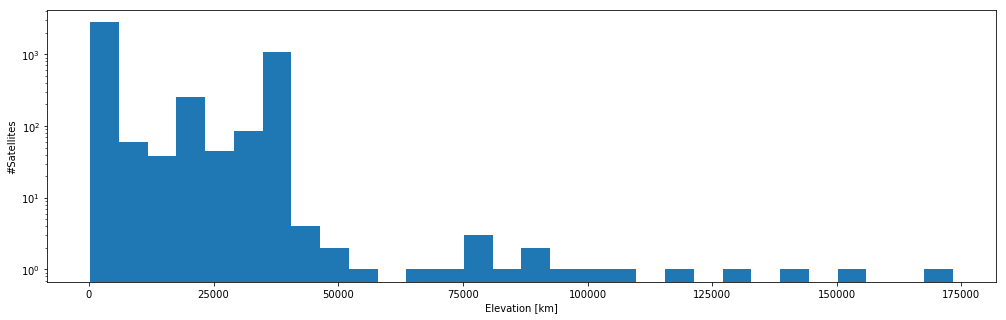

In [26]:
#no_deb["Elevation [km]"].astype("float").plot(kind="bar", bins= 30)
plt.hist(no_deb["Elevation [km]"].astype("float"), bins = 30, log=True)
plt.xlabel("Elevation [km]")
plt.ylabel("#Satellites")
plt.show()

We can observe two main peak. One close to representing satellites orbinting below ~4500 km and one for those orbiting around 35'000 km. Those two bar corresponds to the LEO(Low Earth Orbit) and the GEO/GSO(Geosynchronous/Geostationary orbit). In The middle there is still a lot of satellites, they are called the. The remaining satellites higher than the GEO/GSO are called HEO(High Earth Orbit).

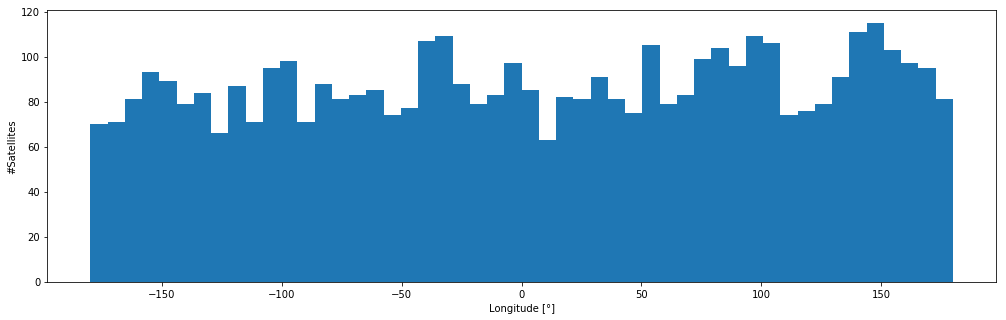

In [33]:
plt.hist(no_deb["Longitude [°]"].astype("float"), bins = 50, log=False)
plt.xlabel("Longitude [°]")
plt.ylabel("#Satellites")
plt.show()

In [34]:
plt.hist(no_deb["Latitude [°]"].astype("float"), bins = 50, log=False)
plt.xlabel("Latitude [°]")
plt.ylabel("#Satellites")
plt.show()

As we can see the satellites a well spead along the whole range of longitude. However it's not the case for the latitudes. At least not for the latitude 0.
The latitude 0 corresponds to the ecuador. And this is where Geostationary satellites are located. Geostationary satellites have the same period as the one from the earth and always have the same positions relatively to the ground.

## 3.2 Satellites in Orbit Info

The second file that we retrieved contain aditional information for each satellites as we can see below

In [36]:
sioi = pd.read_csv("Dataset/satellites_in_orbit_info.csv")
sioi.head()

OBJECT_ID  OBJECT_NAME  NORAD_CAT_ID COUNTRY  PERIOD  INCLINATION  APOGEE  \
0   2017-075D    CZ-2C R/B         43031     PRC   95.19        35.21   599.0   
1   2017-075C  YAOGAN-30 F         43030     PRC   96.62        35.00   604.0   
2   2017-075B  YAOGAN-30 E         43029     PRC   96.62        35.00   604.0   
3   2017-075A  YAOGAN-30 D         43028     PRC   96.62        35.00   603.0   
4  1998-067NL    OSIRIS-3U         43027      US   92.59        51.64   405.0   

   PERIGEE RCS_SIZE  RCSVALUE      LAUNCH COMMENT  
0    457.0      NaN         0  2017-11-24     NaN  
1    590.0      NaN         0  2017-11-24     NaN  
2    590.0      NaN         0  2017-11-24     NaN  
3    590.0      NaN         0  2017-11-24     NaN  
4    398.0      NaN         0  1998-11-20     NaN

We start by cleaning the dataframe before vizualizing it. We start by dropping the columns COMMENT, RCSVALUE and RCS_SIZE because the don't contains information most of the time

In [39]:
sioi = sioi.drop(["COMMENT", "RCSVALUE", "RCS_SIZE"], axis = 1)

We then remove the satellites that have duplicates and that have the DEB extension to be consistent with our previous processing on the tle file. We also remove row that still contains NaN values.

In [41]:
sioi = sioi[["DEB" not in x for x in sioi.OBJECT_NAME ]].drop_duplicates(subset = "OBJECT_NAME")
sioi = sioi.dropna(axis = 0)
sioi.head()

OBJECT_ID  OBJECT_NAME  NORAD_CAT_ID COUNTRY  PERIOD  INCLINATION  APOGEE  \
0   2017-075D    CZ-2C R/B         43031     PRC   95.19        35.21   599.0   
1   2017-075C  YAOGAN-30 F         43030     PRC   96.62        35.00   604.0   
2   2017-075B  YAOGAN-30 E         43029     PRC   96.62        35.00   604.0   
3   2017-075A  YAOGAN-30 D         43028     PRC   96.62        35.00   603.0   
4  1998-067NL    OSIRIS-3U         43027      US   92.59        51.64   405.0   

   PERIGEE      LAUNCH  
0    457.0  2017-11-24  
1    590.0  2017-11-24  
2    590.0  2017-11-24  
3    590.0  2017-11-24  
4    398.0  1998-11-20

We can now plot the apogee for example and we could expect a similar disctribution as the elevation feature for the TLE file.

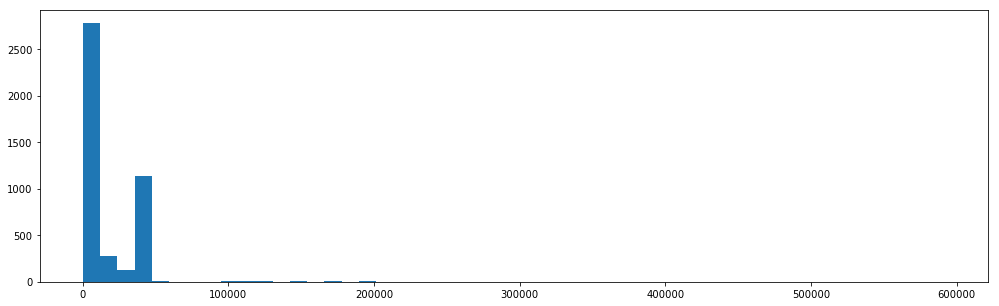

In [48]:
plt.hist(sioi.APOGEE, bins=50)
plt.show()

As we can see the two files don't seem to contains the same set of satellites. We can plot the satellites that have an apogee lower than 175'000 km to compare more precisely the two plots.

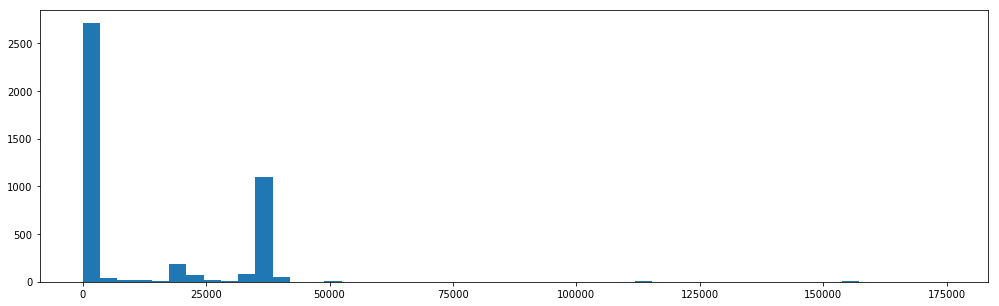

In [49]:
plt.hist(sioi.APOGEE[sioi.APOGEE < 175000], bins=50)
plt.show()

Apparently this file contains informations mainly about LEO and GEO/GSO satellites. In order to use both files in the exploitation we will merge them later.

We can plot the lauchdate histogram of this file

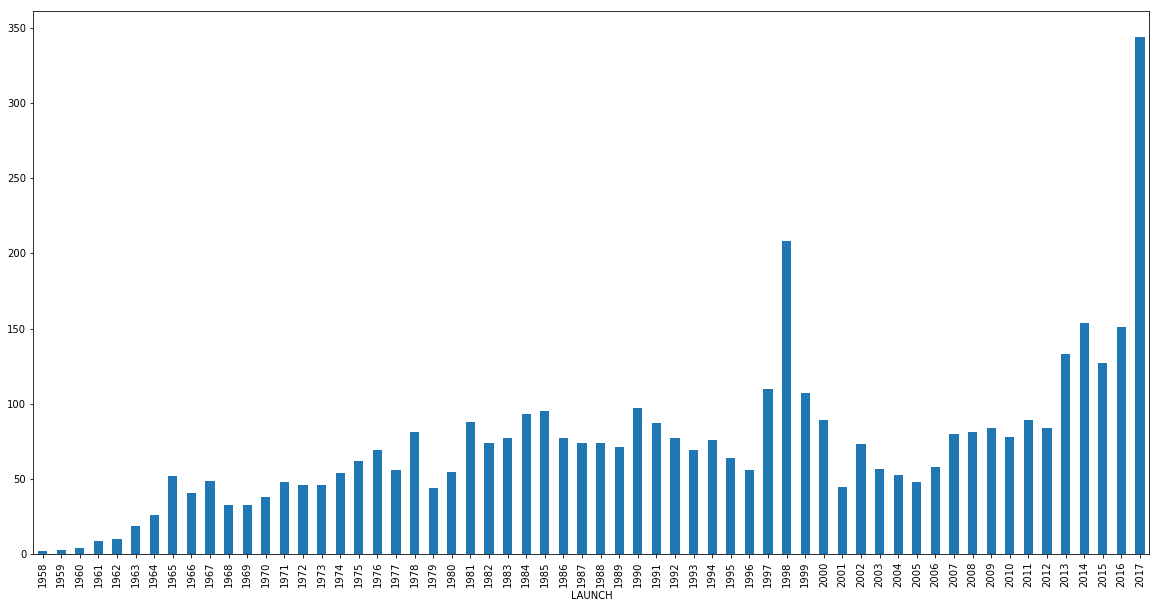

In [50]:
sioi["LAUNCH"]= pd.to_datetime(sioi["LAUNCH"]).apply(lambda x: x.strftime('%Y'))
sioi.groupby("LAUNCH").size().plot(kind="bar", figsize=(20,10))
plt.show()

There is clearly an increasing tendency throughout the years. The exponential behaviour in the latest year could be explained by the democratization of cube satellites lauch for commercial use.

## 3.3 Satellites Statistics per Country

The last file contains various statistics per country

In [53]:
sspc = pd.read_csv("Dataset/sat_statistics_per_country.csv")
sspc.head()

COUNTRY SPADOC_CD  ORBITAL_TBA  \
0  ARAB SATELLITE COMMUNICATIONS ORGANIZATION        AB            0   
1                                ASIASAT CORP        AC            0   
2                                     ALGERIA       ALG            0   
3                                   ARGENTINA      ARGN            0   
4                                     AUSTRIA      ASRA            0   

   ORBITAL_PAYLOAD_COUNT  ORBITAL_ROCKET_BODY_COUNT  ORBITAL_DEBRIS_COUNT  \
0                     13                          0                     0   
1                      8                          0                     0   
2                      5                          0                     0   
3                     17                          0                     0   
4                      3                          0                     0   

   ORBITAL_TOTAL_COUNT  DECAYED_PAYLOAD_COUNT  DECAYED_ROCKET_BODY_COUNT  \
0                   13                      1                          0   
1                    8                      0                          0   
2                    5                      0                          0   
3                   17                      2                          0   
4                    3                      0                          0   

   DECAYED_DEBRIS_COUNT  DECAYED_TOTAL_COUNT  COUNTRY_TOTAL  
0                     0                    1             14  
1                     0                    0              8  
2                     0                    0              5  
3                     0                    2             19  
4                     0                    0              3

This file will not be used in following analysis but for the sake of curiosity we can still plot the distribution of satellites per country

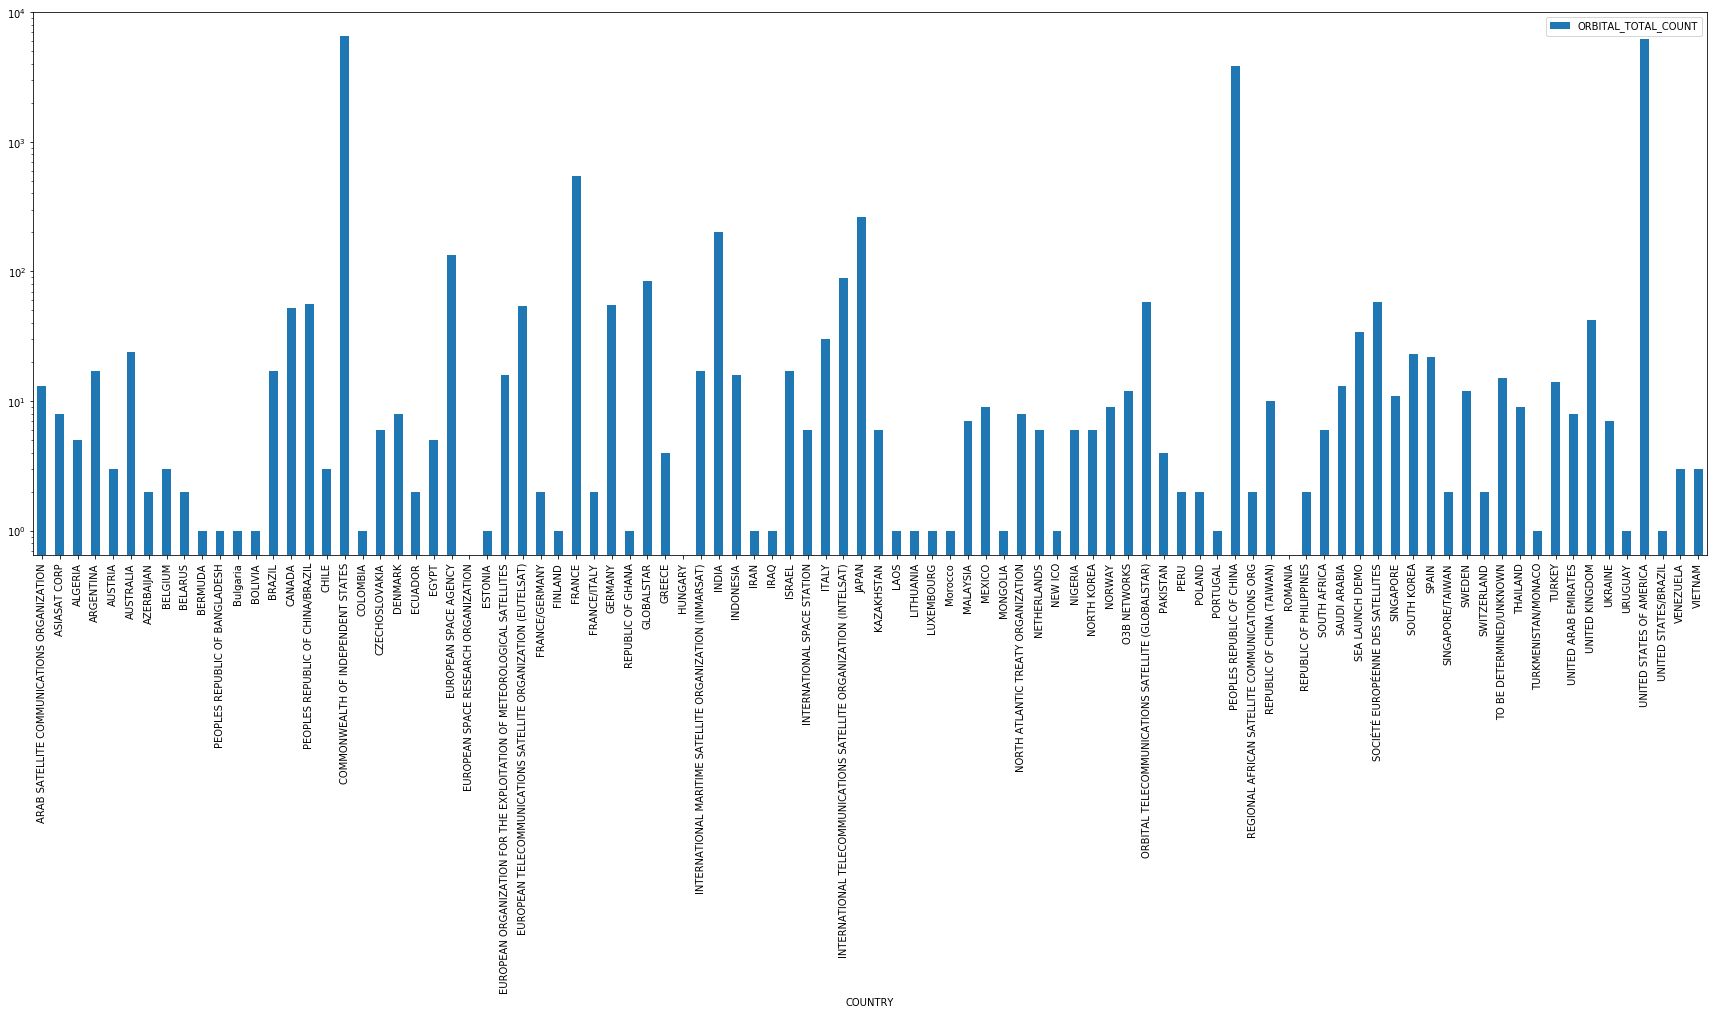

In [54]:
sspc = sspc[["COUNTRY", "ORBITAL_TOTAL_COUNT"]].set_index("COUNTRY")
sspc = sspc.drop("ALL")
sspc.plot(kind='bar', figsize = (30, 10), logy=True)
plt.show()

Not suprisingly the most active countries are the USA, China and Russia (more precisely Commonwealth of independant states)

# 4. Data Exploitation

We will combine the first two files from the exploratory part, namely the tle file and the Satellites in Orbit Info file. As we saw before they don't contains the same data. In order to use data present on both file we will merge both dataframe on their "Object_Name"

In [55]:
#mask = (data_m['Elevation [km]'].astype('float64') < 50000)
#data_final = data_m[mask]
data_m = pd.merge(no_deb,sioi,how='inner', on="OBJECT_NAME")
data_m.head()

OBJECT_NAME        Longitude [°]         Latitude [°] Elevation [km]  \
0    VANGUARD 1   -63.01315328238157   -26.65173623575367    950.1053125   
1    VANGUARD 2   33.607191075144456   -32.25819456312109     2825.77825   
2  VANGUARD R/B   158.90670062542114   1.4622271746404283    746.4226875   
3    VANGUARD 3  -14.979412519707317  -30.811335100669776        3271.14   
4    EXPLORER 7    165.9903034740197    9.845133707399345   517.82565625   

   OBJECT_ID  NORAD_CAT_ID COUNTRY  PERIOD  INCLINATION  APOGEE  PERIGEE  \
0  1958-002B             5      US  132.75        34.24  3834.0    650.0   
1  1959-001A            11      US  121.47        32.87  2940.0    553.0   
2  1958-002A            16      US  137.32        34.28  4223.0    655.0   
3  1959-007A            20      US  124.62        33.35  3263.0    510.0   
4  1959-009A            22      US   96.36        50.28   683.0    486.0   

  LAUNCH  
0   1958  
1   1959  
2   1958  
3   1959  
4   1959

In [140]:
np.shape(data_final)

(4347, 16)

## 4. Data Exploitation

As one can observe, we had a rich amount of data. The goal of our first investigation was to find a way to group different satellite categories. To perform such a thing, we decided to cluster the satellites with respect to their orbit as the use of a Graph was a huge plus to perform this clustering. Moreover, we observed on [this](https://in-the-sky.org/satmap_worldmap.php) website that we should find a principal orbit oscillating around the equator which was a welcomed hint to be able to assess wheter our results are coherent.

In [141]:
dict_tle = {}
for i in range(0,len(lines_tot)-1,3):
    dict_tle[lines_tot[i][2:].strip('\n')] = (lines_tot[i+1],lines_tot[i+2])
    
keys = list(dict_tle.keys())
for i in keys:
    if i not in data_final['OBJECT_NAME'].values:
        del dict_tle[i]

As said before, we want to solve our problematic using a graph. To do so, we had to think about a metric to compare the different satellites. <br>
We decided to create a binary map for each satellites showing their trajectory during a single period. First, we sampled each satellite period by a fixed number of samples (in our case, we chose 200) and computed the satellites positions at each time sample using the [PyEphem](http://rhodesmill.org/pyephem/) library and the TLE file. The results were plotted on an array of size 180x360 where 180 and 360 represents the spread of the latitude and longitude respectively. <br>
Such a metric is similar to projecting the satellites' positions into a 2D plane representing the earth's surface. A single projection into a discrete point was too precise in our case and would make the comparison between the satellites impossible. To solve this problem, we projected the satellites positions into a square of fixed side length.

In [142]:
res = []
for i in (dict_tle.keys()):
    res.append(satellite_orbit(i,sioi,dict_tle))

In [143]:
orbit_grids = compute_grids(res)

Typical results of our mapping is shown on the next Figure. 

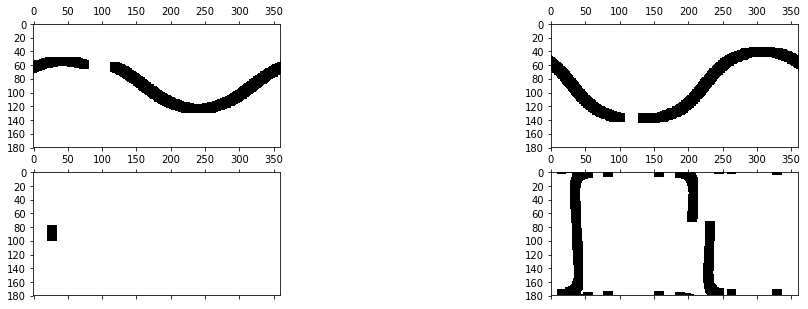

In [144]:
fig, axes = plt.subplots(2,2)
axes[0,0].spy(orbit_grids[0])
axes[0,1].spy(orbit_grids[5])
axes[1,0].spy(orbit_grids[200])
axes[1,1].spy(orbit_grids[150])

We could already observe from the first two plots that most of the satellites had a close trajectory with different phases. <br>
One can observe that a recurrent gap is present between the two tails of each plot. This is due to the approximation of the movement function computed by PyEphem and the period being supposedly not totally accurate. <br> 
The third plot is a typical example of the movement of a geostationnary satellite during one entire period. Indeed, as said before, a geostationnary satellite always cover the same area over time.<br>
The fourth image shows a flaw of our representation. Considering a fixed sampling rate and a squared representation of the earth's surface, the speed of the satellites are not constant in our referential. Hence, the sampled positions are not equidistant. <br>
Moreover, after a single period, some satellites undergo a large phase shift as can be seen on the fourth plot. This is the principal reason why we did not compute the trajectory of the satellites over more than one period. From one point, the satellite would have covered most of the map and this would falsify our results.

Let's have a look at all our satellites on a world map.

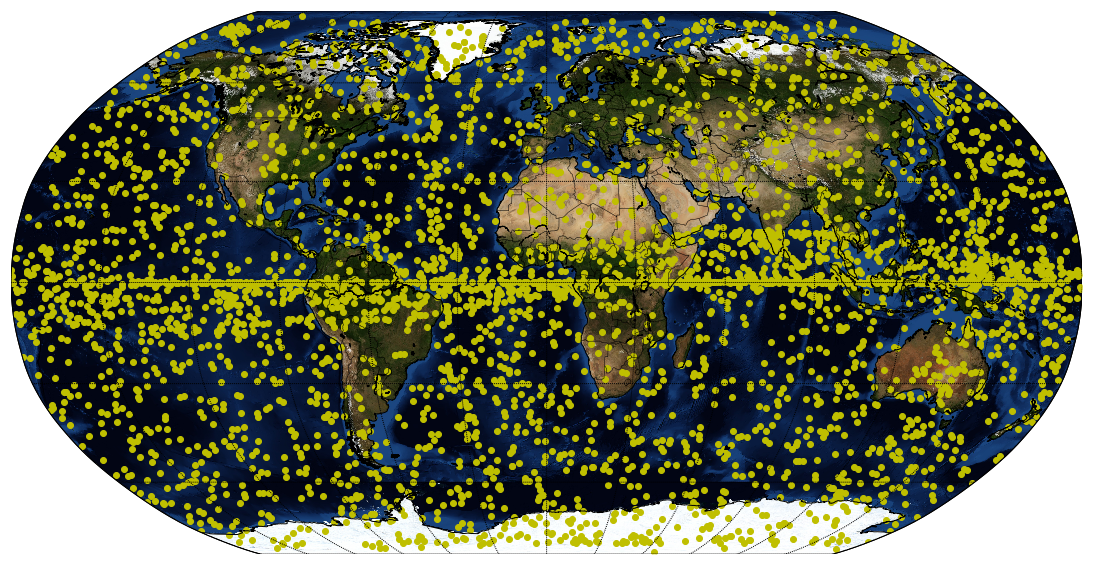

In [146]:
plot_map(data_final)

Without any processing, satellites are covering most of the globe. Hence this raw data cannot be used to process some analysis. <br>
However, The latter plot already illustrates some of the different clusters we want to highlight. The most remarkable is the geostationnary cluster being the dense line along the equator. One pattern moving down the Atlantic sea and reaching up over Australia and the Philippines sea can also be noticed.

Now we had to define a metric to compare our different grid maps. To do so, we decided to apply a logical "and" between the binary maps and taking the sum of the resulting matrix to define the weight between two satellites. This would give a high coefficient for satellites having the same trajectory. A high coefficient is directly proportional to a high weight, hence we did not have use another mathematical tool such as a decreasing exponential to make small coefficients become a high weight.

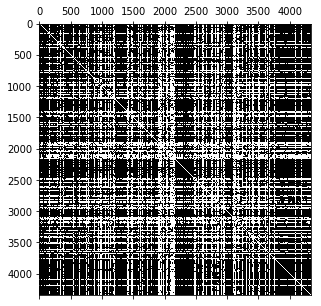

In [79]:
adja = compute_adja(orbit_grids)
plt.spy(adja)

The resulting blank lines are probably from the geostationnary satellites having only a small amount of pixels in common with other trajectories. <br>
The next step is to filter the satellites having a small amount of pixels in common. To do such a thing, we applied a simple threshold.

In [147]:
threshold = 8000
final = adja*(adja>threshold)
plt.spy(final)

The resulting matrix is really sparse. For such a huge matrix (4347x4347) it was necessary to sparsify it to be able to perform a coherent clustering without too much noise.

Let's have a look at the graph with the [PyGSP](https://github.com/epfl-lts2/pygsp) library.

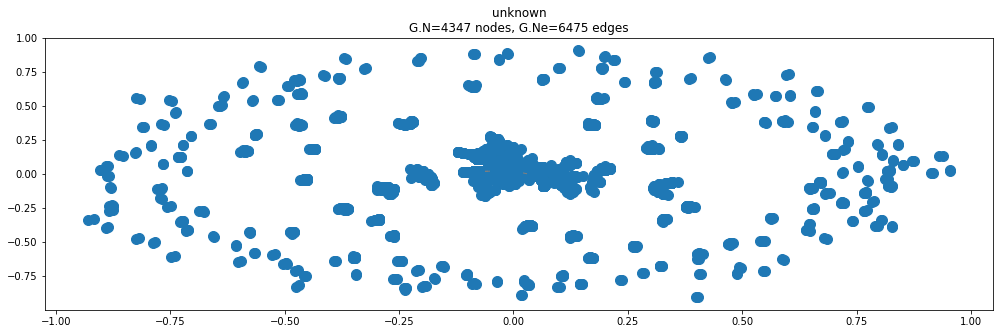

In [193]:
G = graphs.Graph(final)
G.set_coordinates('spring')
G.plot()

The spring coordinates allowed us to identify a central pattern. Let's apply a DBSCAN algorithm to the latter coordinates to isolate this central pattern

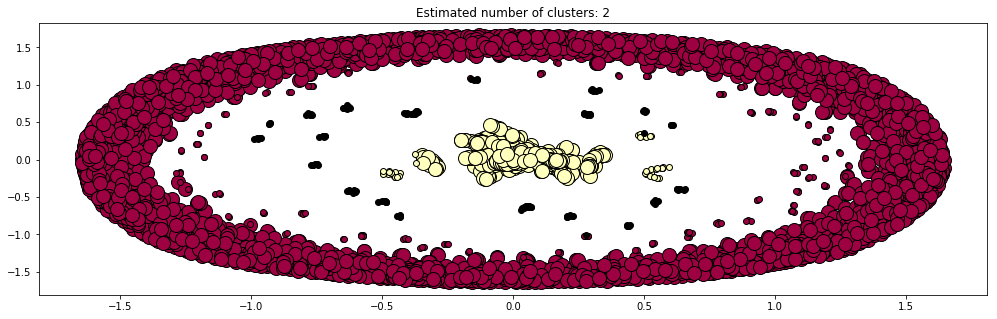

In [194]:
labels1 = dbscan_func(G,0.3,100)

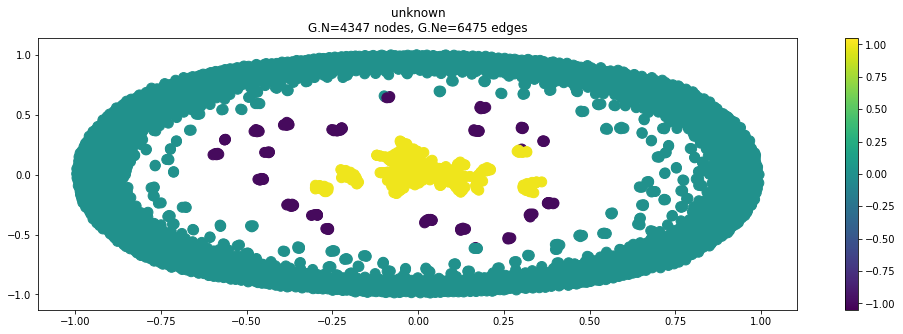

In [195]:
G.plot_signal(labels1)

We are interested in the points having the label 1. Let's plot the respective sattellites on a world map.

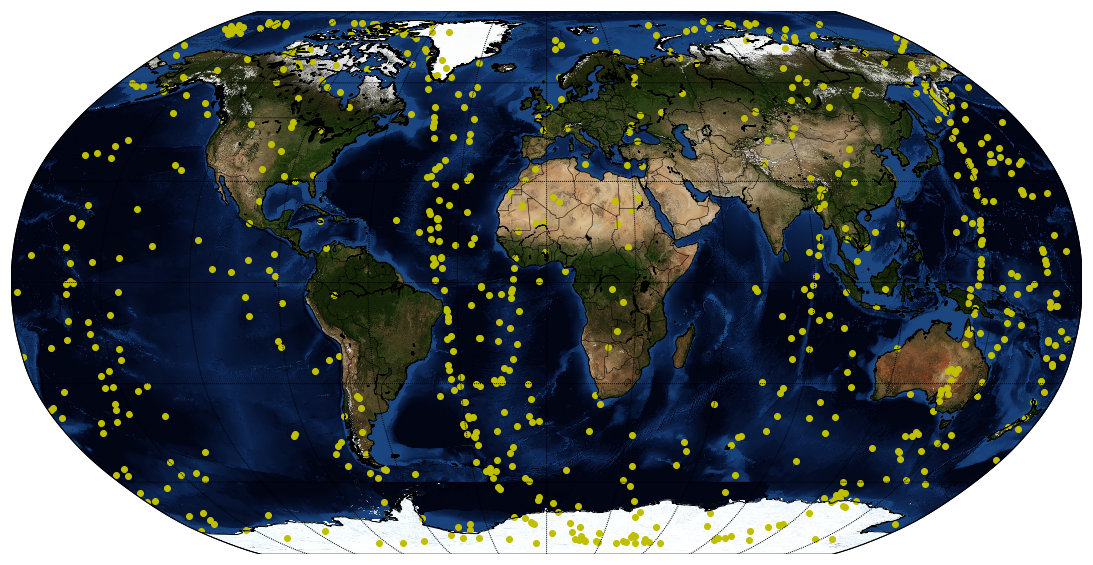

In [196]:
plot_map(data_final,labels1,1)

We can observe that this central pattern really had a meaning with respect to our goal. The plotted satellites have the same orbit with different phase shifts. 
The next step is to cluster these different phases. To do so, let's process another DBSCAN on these satellites.

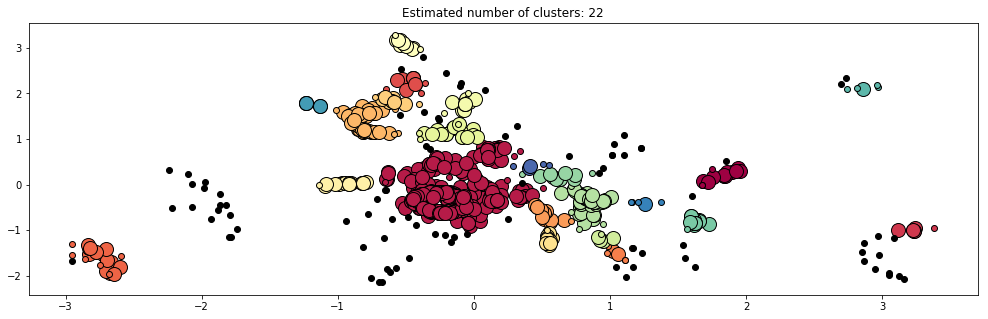

In [218]:
labels2 = dbscan_func(G,0.15,5,labels1,1)

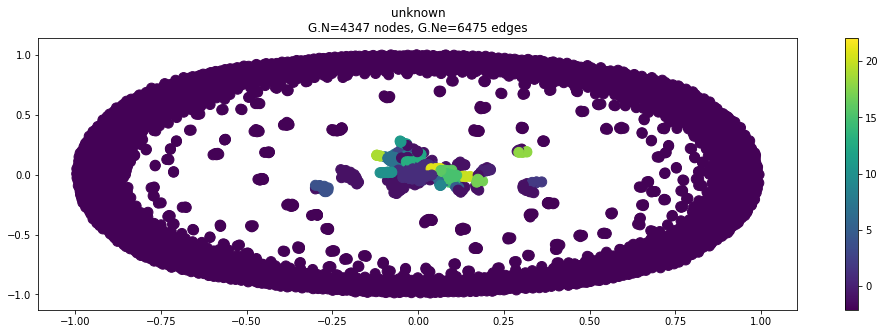

In [219]:
indices = np.where(labels1==1)
labels3 = np.ones(len(labels1))*(-2)
labels3[[indices]] = labels2
G.plot_signal(labels3)

This latter processing allowed us to cluster the trajectories with respect to their phase shift. The plot illustrated below shows the pricipal trajectory that we already observed in the first world map plot. The previous processing allowed us to isolate it in a single cluster. 
Moreover the second plot confirms that the clustering has been done with respect to their phase shift.

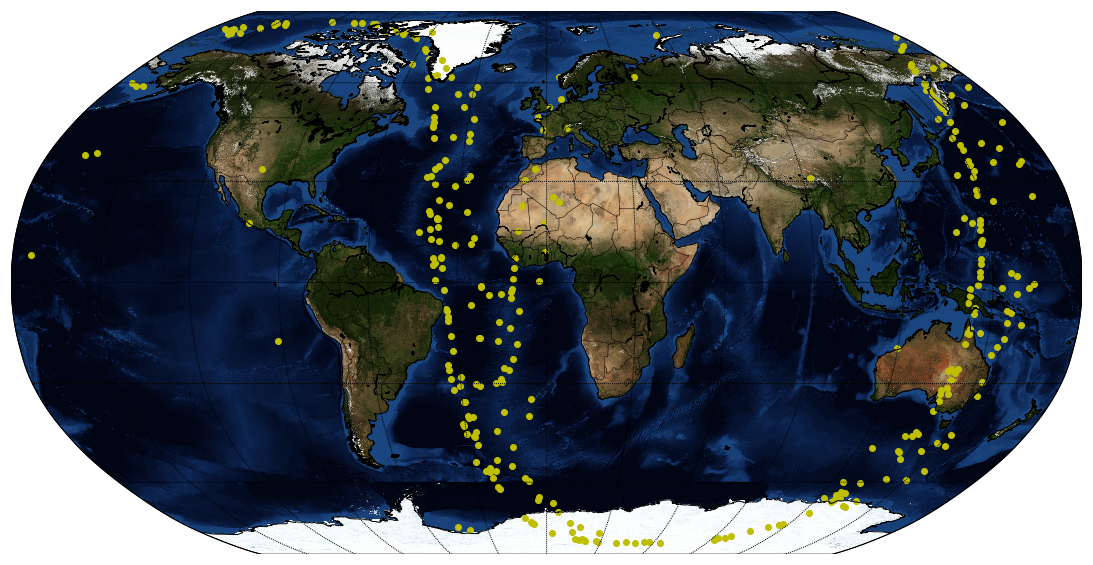

In [221]:
plot_map(data_final,labels3,1)

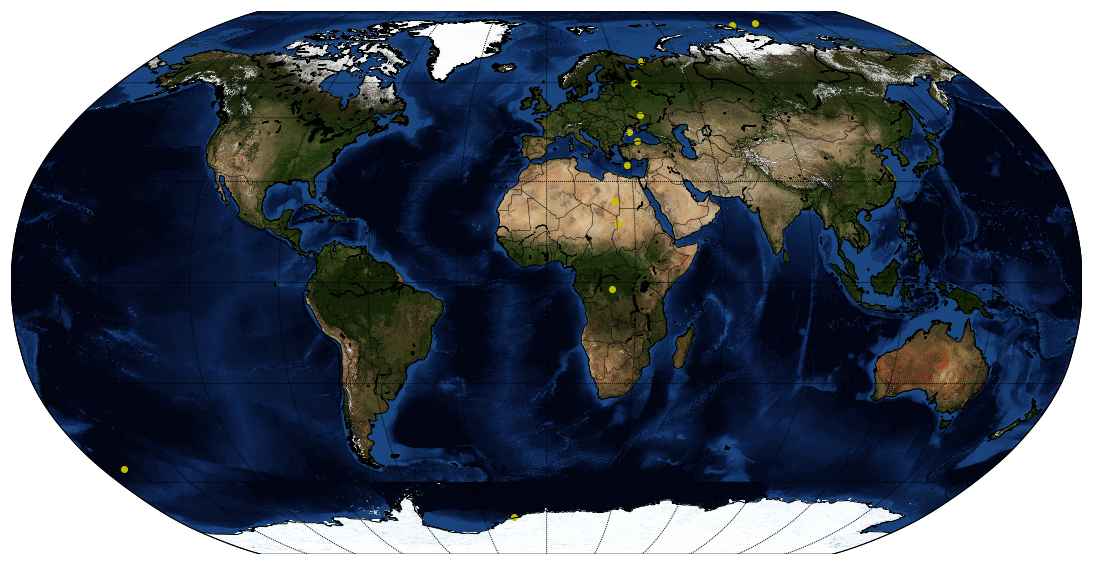

In [226]:
plot_map(data_final,labels3,6)

As said before, the geostationnary satellites always cover the same area of the earth's surface over time. That's why, considering our metric, we cannot cluster them. <br>
However, there is a simpler way without using any graph to observe them. As their area of observed surface is really small, we can perform a threshold directly on the metric's coefficients. This will isolate the satellites covering small areas. As all the other satellites oscillates, they're area must be bigger that the geostationary's.

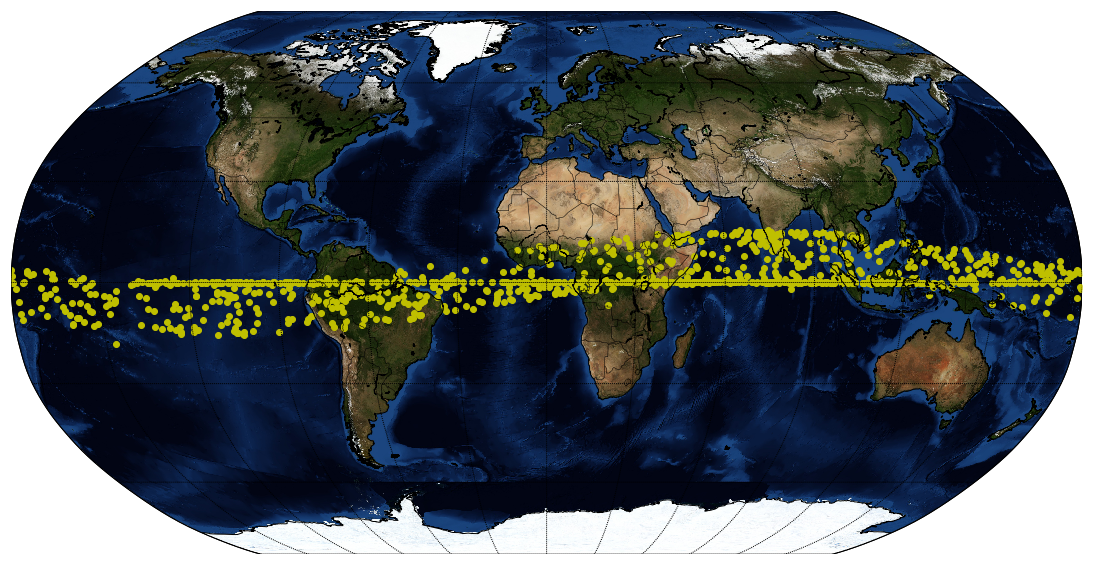

In [209]:
summ = np.zeros([len(orbit_grids),1])
for n,i in enumerate(orbit_grids):
    summ[n] = np.sum(i)
summ = summ*(summ<1000)
mask = summ>0
mask = (mask==True).T[0]
plot_map(data_final,mask.T,True)

The simple threshold worked without any noise. We were able to highlight the geostationnary satellites without the use of any graph processing.